In [6]:
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader

In [7]:
from dataset import PascalPartDataset
from lightning_module import PascalPartModel

In [8]:
# Set random seeds for reproducibility
seed = 42
pl.seed_everything(seed=seed, workers=True)

# Specify experiment details
project = 'PascalPart'  # Update this with your project name
port = '3033'  # Update this if needed
experiment_name = project

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [9]:
# Set the tracking URI for mlflow
mlflow.set_tracking_uri(f'http://localhost:{port}')
mlflow.set_experiment(experiment_name)

# Fetch the experiment details
experiment = mlflow.get_experiment_by_name(experiment_name)

# Load the best model from the mlflow experiment
# best_run = mlflow.search_runs(experiment_ids=[experiment.experiment_id], order_by=['metrics.val_loss ASC']).iloc[0]
best_run = mlflow.search_runs(experiment_ids=[experiment.experiment_id], order_by=['start_time DESC']).iloc[0]
best_model_uri = best_run.artifact_uri + '/model'
model = mlflow.pytorch.load_model(best_model_uri)

In [10]:
best_run

run_id                                                     76727c0be5da4d5392a9d6b965a7618a
experiment_id                                                                             1
status                                                                             FINISHED
artifact_uri                              /storage/AIDA_PROJECTS/egor.koptelov/MIL_test_...
start_time                                                 2024-08-22 08:35:06.101000+00:00
end_time                                                   2024-08-22 09:56:34.175000+00:00
metrics.train_jaccard_loss_mIoU_0                                                  0.999982
metrics.val_jaccard_loss_mIoU_0                                                    0.999943
metrics.train_loss                                                                 0.090285
metrics.train_total_jaccard_loss                                                   0.892234
metrics.train_jaccard_loss_mIoU_1                                               

In [11]:
df_train_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})
df_val_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})

# extract names of images and masks for train and val splts
splits = ["train_id", "val_id"]
splits_samples = {}

for split in splits:
    with open(f'/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/hierarchical_segmentation/data/{split}.txt') as f:
        splits_samples[split] = f.read().splitlines()

path_to_raw = '/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part/Pascal-part'

# create dataframes with full paths to images and masks
df_train_paths['PATH_TO_IMAGE'] = [f'{path_to_raw}/JPEGImages/{id_img}.jpg' for id_img in splits_samples['train_id']]
df_train_paths['PATH_TO_MASK'] = [f'{path_to_raw}/gt_masks/{id_mask}.npy' for id_mask in splits_samples['train_id']]
df_val_paths['PATH_TO_IMAGE'] = [f'{path_to_raw}/JPEGImages/{id_img}.jpg' for id_img in splits_samples['val_id']]
df_val_paths['PATH_TO_MASK'] = [f'{path_to_raw}/gt_masks/{id_mask}.npy' for id_mask in splits_samples['val_id']]

In [12]:
# extract transform
transform = model.transform
mean, std = transform[1].mean, transform[1].std

# Create the validation dataset and dataloader
val_dataset = PascalPartDataset(df_val_paths, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [13]:
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

In [18]:
# Visualize a few samples
def visualize_predictions(model, dataloader, num_samples, std, mean):
    model.eval()

    with torch.no_grad():
        for i, (image, mask) in enumerate(val_loader):
            if i >= num_samples:
                break
            
            # Forward pass through the model
            body_output, upper_lower_body_output, body_parts_output = model(image)
            
            # Convert model outputs to predictions
            body_pred = torch.argmax(body_output, dim=1)  # torch.sigmoid(body_output) > 0.5
            upper_lower_pred = torch.argmax(upper_lower_body_output, dim=1) # torch.sigmoid(upper_lower_body_output) > 0.5
            body_parts_pred = torch.argmax(body_parts_output, dim=1)
            

            denorm_image = denormalize(image[0], mean, std)
            # Visualize the results
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 5, 1)
            plt.title('Input Image')
            plt.imshow(denorm_image.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')

            plt.subplot(1, 5, 2)
            plt.title('Ground Truth Mask')
            plt.imshow(mask[0].permute(1, 2, 0).cpu().numpy(), 
                        # cmap='gray'
            )
            plt.axis('off')

            plt.subplot(1, 5, 3)
            plt.title('Predicted Body Mask')
            plt.imshow(body_pred.permute(1, 2, 0).cpu().numpy(), 
                        # cmap='gray'
            )
            plt.axis('off')

            plt.subplot(1, 5, 4)
            plt.title('Predicted Up/Low Body Mask')
            plt.imshow(upper_lower_pred.permute(1, 2, 0).cpu().numpy(), 
                        # cmap='gray'
            )
            plt.axis('off')

            plt.subplot(1, 5, 5)
            plt.title('Predicted Body parts Mask')
            plt.imshow(body_parts_pred.permute(1, 2, 0).cpu().numpy(), 
                        # cmap='gray'
            )
            plt.axis('off')

            plt.show()

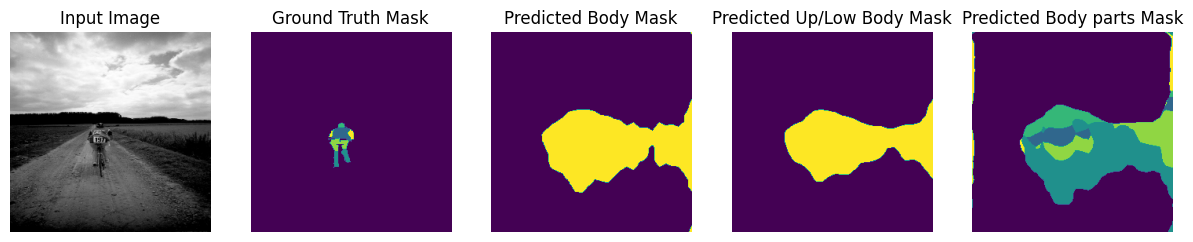

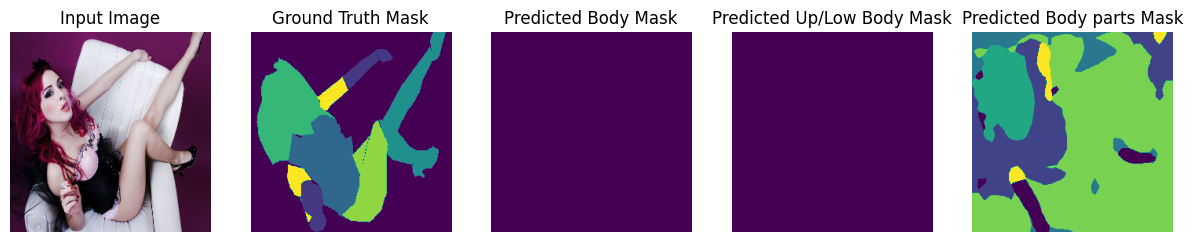

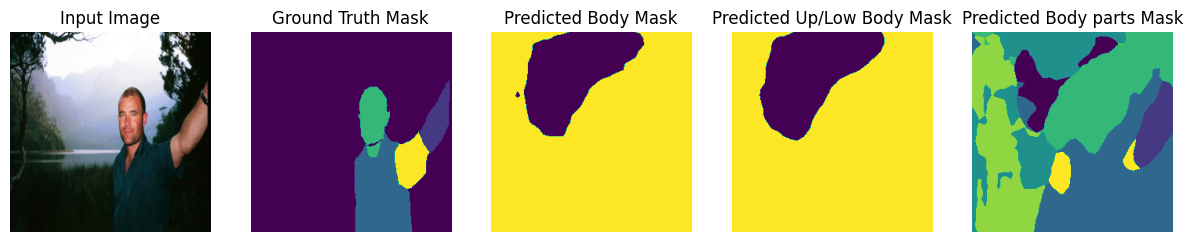

In [19]:
visualize_predictions(model, val_loader, num_samples=3, mean=mean, std=std)